In [1]:
import re
import os
import difflib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
main_table = pd.read_csv(os.path.join(cwd, '../MainTable.csv'))

main_table.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,TermID,AssignmentID,ProblemID,...,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
0,0,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,1804399,True,Run.Program,1.0,NaN,NaN,NaN,32-84779,NaN,NaN
1,1,14502,Java 8; CodeWorkout,2019-03-20T19:34:25,0,CS 1114,410.0,spring-2019,492.0,32,...,1804399,True,Compile,NaN,Success,NaN,NaN,32-84780,32-84779,NaN
2,2,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,1805146,True,Run.Program,1.0,NaN,NaN,NaN,32-84781,NaN,NaN
3,3,13504,Java 8; CodeWorkout,2019-03-20T21:02:00,0,CS 1114,407.0,spring-2019,492.0,32,...,1805146,True,Compile,NaN,Success,NaN,NaN,32-84782,32-84781,NaN
4,4,13499,Java 8; CodeWorkout,2019-03-20T21:13:09,0,CS 1114,410.0,spring-2019,492.0,32,...,1805216,True,Run.Program,0.0,NaN,NaN,NaN,32-84783,NaN,NaN


In [3]:
main_table['AssignmentID+ProblemID'] = main_table['AssignmentID'].astype(str) + " " + main_table['ProblemID'].astype(str)
subtable = main_table[['Order', 'SubjectID', 'ServerTimestamp', 'CourseSectionID', 'AssignmentID+ProblemID', 'CodeStateID', 'Score']]
subtable = subtable.drop_duplicates(subset=['CodeStateID'], keep='first')

In [4]:
df = subtable.groupby(['SubjectID', 'CourseSectionID', 'AssignmentID+ProblemID']).apply(lambda x: pd.Series({
    'CodeStateID': x['CodeStateID'].tolist(),
    'Score': x['Score'].tolist(),
    'ServerTimestamp': x['ServerTimestamp'].tolist(),
})).reset_index()

df['num_snapshots'] = df['CodeStateID'].apply(lambda x: len(x))
df['time_to_solve'] = df['ServerTimestamp'].apply(lambda x: (pd.to_datetime(x[-1]) - pd.to_datetime(x[0])).seconds)
df['time_between_snapshots'] = df['ServerTimestamp'].apply(lambda x: [(pd.to_datetime(x[i]) - pd.to_datetime(x[i-1])).seconds for i in range(1, len(x))])
df['success'] = df['Score'].apply(lambda x: 1 if x[-1] == 1 else 0)

/tmp/ipykernel_429735/4128878160.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = subtable.groupby(['SubjectID', 'CourseSectionID', 'AssignmentID+ProblemID']).apply(lambda x: pd.Series({


In [5]:
all_courses_without_one_snapshot = df[df['num_snapshots'] > 1]
df_without_break = all_courses_without_one_snapshot[all_courses_without_one_snapshot['time_between_snapshots'].apply(lambda x: max(x) <= 600)]


In [6]:
len(df_without_break[df_without_break['success'] == 0]) / len(df_without_break) * 100

8.206106870229007

Details on Data:

In [7]:
number_of_snapshots = df['num_snapshots'].sum()
number_of_students = df['SubjectID'].nunique()
number_of_assignments = df['AssignmentID+ProblemID'].nunique()
number_of_sections = df['CourseSectionID'].nunique()
unique_student_problem_combinations_count  = df.groupby(['SubjectID', 'AssignmentID+ProblemID']).size().reset_index(name='counts').shape[0] # how many problems and students
print(f"Number of snapshots: {number_of_snapshots}")
print(f"Number of students: {number_of_students}")
print(f"Number of assignments: {number_of_assignments}")
print(f"Number of sections: {number_of_sections}")
print(f"Number of students and problems: {unique_student_problem_combinations_count}")

Number of snapshots: 69627
Number of students: 413
Number of assignments: 50
Number of sections: 2
Number of students and problems: 16179


#### Quetion per Student

(array([  9.,  27.,   9.,  18.,   5.,  33.,  11.,  73.,  25., 203.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

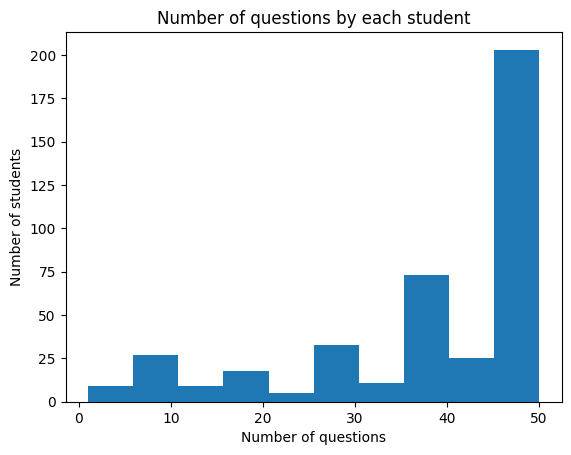

In [8]:
x = sorted(df.groupby('SubjectID')['AssignmentID+ProblemID'].nunique())
plt.title('Number of questions by each student')
plt.xlabel('Number of questions')
plt.ylabel('Number of students')
plt.hist(x)

#### Successful

In [9]:
df['Max.Score'] = df['Score'].apply(lambda x: max(x))
successfull = df[df['Max.Score'] == 1]
not_successfull = df[df['Max.Score'] < 1]
len(successfull), len(not_successfull)

(15024, 1155)

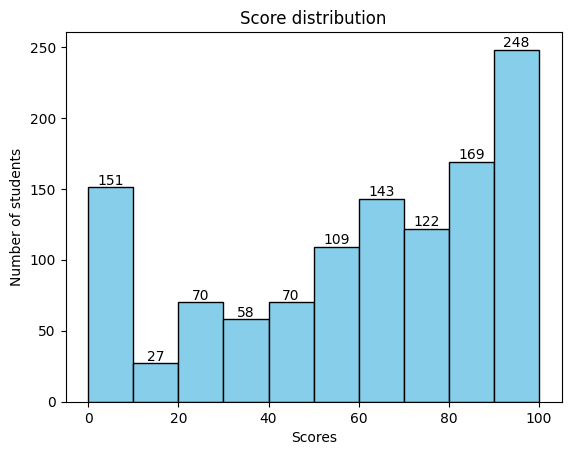

In [10]:
x = df[df['success'] == 0]['Max.Score'].apply(lambda x: 100 * x)
plt.title('Score distribution')
plt.xlabel('Scores')
plt.ylabel('Number of students')
n, bins, patches = plt.hist(x, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), int(patches[i].get_height()), ha='center', va='bottom')

plt.show()

#### Snapshots per Student

In [11]:
snapshot_stat = df.groupby(['AssignmentID+ProblemID']).apply(lambda x: pd.Series({
    'number_of_students': x['SubjectID'].nunique(), 
    'min_snapshots': x['num_snapshots'].min(),
    'max_snapshots': x['num_snapshots'].max(),
    'mean_snapshots': x['num_snapshots'].mean(),
    'median_snapshots': x['num_snapshots'].median(),
})).reset_index()

snapshot_stat

/tmp/ipykernel_429735/4175279888.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  snapshot_stat = df.groupby(['AssignmentID+ProblemID']).apply(lambda x: pd.Series({


,AssignmentID+ProblemID,number_of_students,min_snapshots,max_snapshots,mean_snapshots,median_snapshots
0,439.0 1,365.0,1.0,50.0,2.383562,2.0
1,439.0 12,362.0,1.0,75.0,2.182320,1.0
2,439.0 13,386.0,1.0,69.0,8.784974,6.0
3,439.0 232,378.0,1.0,51.0,5.973545,3.0
4,439.0 233,364.0,1.0,35.0,3.184066,2.0
5,439.0 234,367.0,1.0,24.0,3.190736,2.0
6,439.0 235,370.0,1.0,27.0,3.262162,2.0
7,439.0 236,366.0,1.0,28.0,3.243169,2.0
8,439.0 3,363.0,1.0,32.0,3.619835,2.0
9,439.0 5,365.0,1.0,31.0,3.471233,2.0


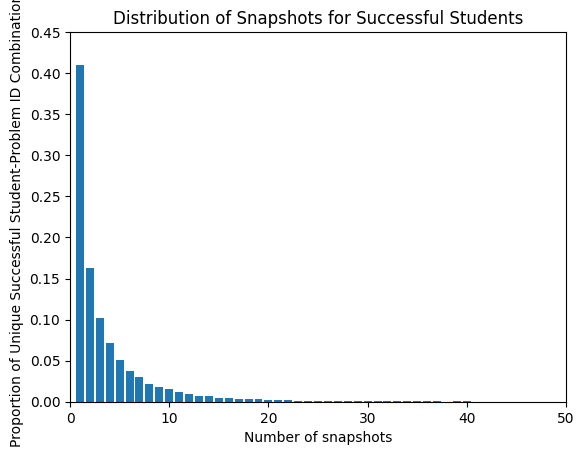

In [12]:
plt.title('Distribution of Snapshots for Successful Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Successful Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

success = df[df['success'] == 1]['num_snapshots']
success = success.value_counts(normalize=True).sort_index()
plt.bar(success.index, success.values)
plt.show()

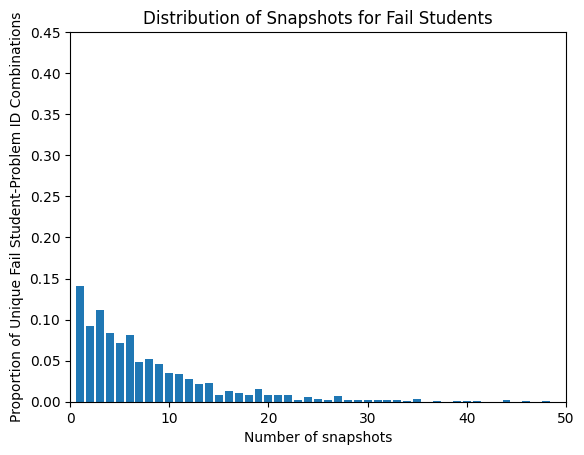

In [13]:
plt.title('Distribution of Snapshots for Fail Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Fail Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

fail = df[df['success'] == 0]['num_snapshots']
fail = fail.value_counts(normalize=True).sort_index()
plt.bar(fail.index, fail.values)
plt.show()

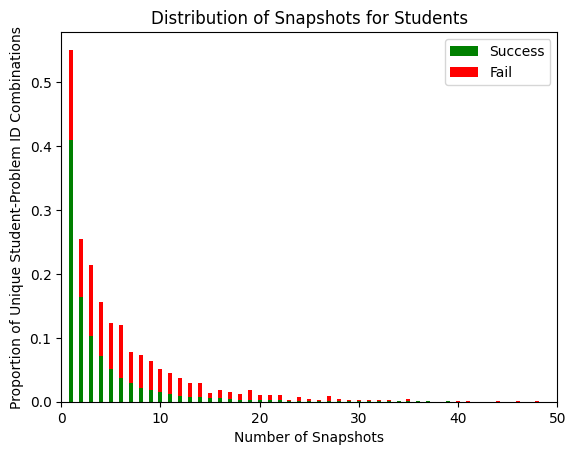

In [14]:
combined_index = success.index.union(fail.index)
success = success.reindex(combined_index, fill_value=0)
fail = fail.reindex(combined_index, fill_value=0)

plt.xlim(0, 50)

bar_width = 0.4
plt.bar(combined_index, success.values, width=bar_width, color='g', label='Success')
plt.bar(combined_index, fail.values, bottom=success.values, width=bar_width, color='r', label='Fail')

plt.title('Distribution of Snapshots for Students')
plt.xlabel('Number of Snapshots')
plt.ylabel('Proportion of Unique Student-Problem ID Combinations')
plt.legend()
plt.show()

#### Time

In [15]:
df_without_one_snapshot = df[df['num_snapshots'] > 1]
time_stat = df_without_one_snapshot.groupby(['AssignmentID+ProblemID']).apply(lambda x: pd.Series({
    'number_of_students': x['SubjectID'].nunique(), 
    'min_time_to_solve': x['time_to_solve'].min()/60,
    'max_time_to_solve': x['time_to_solve'].max()/60,
    'mean_time_to_solve': x['time_to_solve'].mean()/60,
    'median_time_to_solve': x['time_to_solve'].median()/60,
    'mean_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).mean()/60,
    'median_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).median()/60,
})).reset_index()

time_stat # in minutes

/tmp/ipykernel_429735/1333204208.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_stat = df_without_one_snapshot.groupby(['AssignmentID+ProblemID']).apply(lambda x: pd.Series({


,AssignmentID+ProblemID,number_of_students,min_time_to_solve,max_time_to_solve,mean_time_to_solve,median_time_to_solve,mean_time_between_snapshots,median_time_between_snapshots
0,439.0 1,185.0,0.016667,1405.200000,19.864234,0.683333,5.538855,0.438333
1,439.0 12,141.0,0.083333,1400.300000,29.915839,0.550000,13.180828,0.400000
2,439.0 13,326.0,0.150000,1397.016667,111.194018,10.200000,13.033900,1.706250
3,439.0 232,284.0,0.083333,1415.950000,44.804695,3.275000,6.949188,0.767917
4,439.0 233,209.0,0.050000,321.516667,9.593780,1.833333,4.094979,0.737500
5,439.0 234,229.0,0.100000,1426.050000,21.981514,1.433333,9.819502,0.570833
6,439.0 235,228.0,0.133333,1174.966667,20.677778,2.483333,3.412073,0.990833
7,439.0 236,230.0,0.000000,1269.350000,14.428406,2.116667,2.522070,0.706173
8,439.0 3,223.0,0.000000,1183.283333,24.195516,2.650000,4.086803,0.871429
9,439.0 5,208.0,0.000000,1410.533333,22.114343,2.350000,8.900460,0.793750


In [16]:
df_at_least_10 = df_without_one_snapshot[df_without_one_snapshot['num_snapshots'] >= 10]

time_vs_snapshots = {}
for index, row in df_at_least_10.iterrows():
    if row['AssignmentID+ProblemID'] not in time_vs_snapshots:
        time_vs_snapshots[row['AssignmentID+ProblemID']] = {}
    for i in range (1, row['num_snapshots']):
        if i not in time_vs_snapshots[row['AssignmentID+ProblemID']]:
            time_vs_snapshots[row['AssignmentID+ProblemID']][i] = []
        time_vs_snapshots[row['AssignmentID+ProblemID']][i].append(row['time_between_snapshots'][i - 1])

time_vs_snapshots
avg_snapshots_vs_time = {}
len_snapshots_vs_time = {}
for key, value in time_vs_snapshots.items():
    avg_snapshots_vs_time[key] = {}
    len_snapshots_vs_time[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_time[key][k] = sum(v) / len(v)
        len_snapshots_vs_time[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_time.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'AssignmentID+ProblemID': key, 'Snapshot': k, 'Time between Snapshots': v, 'Number of Students': len_snapshots_vs_time[key][k]})

len_snapshots_vs_time = pd.DataFrame(data)


In [17]:
len_snapshots_vs_time = len_snapshots_vs_time[len_snapshots_vs_time['Number of Students'] > 10]
len_snapshots_vs_time['Time between Snapshots'] = len_snapshots_vs_time['Time between Snapshots'].apply(lambda x: x / 60)


Text(0.5, 1.0, 'Time between Snapshots vs Snapshots')

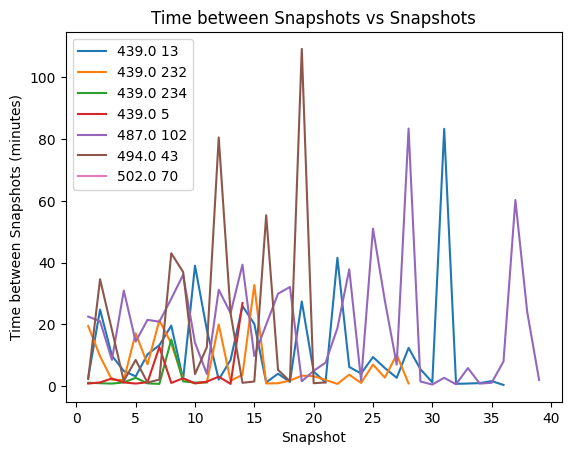

In [18]:
save_data = {}
fig, ax = plt.subplots()
for key, grp in len_snapshots_vs_time.head(150).groupby('AssignmentID+ProblemID'):
    save_data[key] = grp
    ax.plot(grp['Snapshot'], grp['Time between Snapshots'], label=key)
ax.legend()
plt.xlabel('Snapshot')
plt.ylabel('Time between Snapshots (minutes)')
plt.title('Time between Snapshots vs Snapshots')

Checking why consecutive snapshots are done with almost zero delay between them

In [19]:
for key, value in save_data.items():
    print(f"Minimum time to solve {key} is {value['Time between Snapshots'].min().round(2)}")

Minimum time to solve 439.0 13 is 0.33
Minimum time to solve 439.0 232 is 0.67
Minimum time to solve 439.0 234 is 0.66
Minimum time to solve 439.0 5 is 0.66
Minimum time to solve 487.0 102 is 0.46
Minimum time to solve 494.0 43 is 0.88
Minimum time to solve 502.0 70 is 1.53


Time between snapshots for 14352 is [51, 65585, 17, 12, 36, 79, 21, 13, 13] (seconds)
Time between snapshots for 14286 is [25, 43, 118, 91, 56, 11639, 20, 34, 15] (seconds)
Time between snapshots for 14501 is [10, 226, 487, 42, 44, 35430, 223, 50, 17455] (seconds)
Time between snapshots for 14442 is [35, 124, 84, 17, 136, 159, 28110, 10, 38] (seconds)
Time between snapshots for 14199 is [19, 43, 63, 47, 77, 16, 39, 3279, 25] (seconds)
Time between snapshots for 14186 is [34, 5435, 16, 252, 14, 29, 38, 135, 39] (seconds)


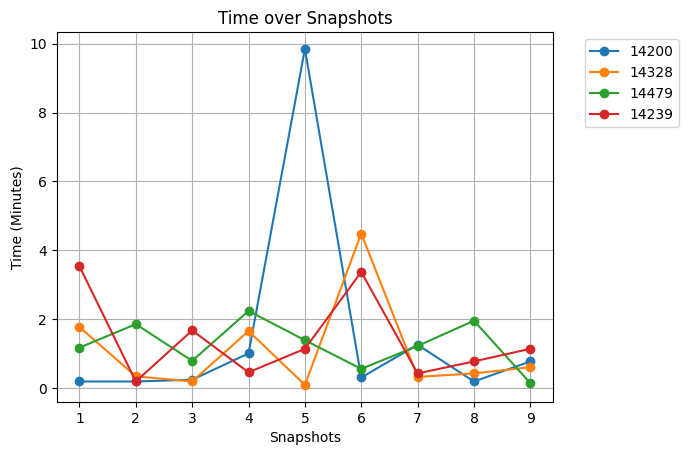

In [20]:
save_data = {}
random_10_fail = not_successfull[not_successfull["num_snapshots"] == 10].sample(10)
for index, row in random_10_fail.iterrows():
    if max(row['time_between_snapshots']) / 60 > 10:
        print(f"Time between snapshots for {row['SubjectID']} is {row['time_between_snapshots']} (seconds)")
        continue
    save_data[index] = row
    snapshots = list(range(1, row['num_snapshots']))
    t = [x/60 for x in row['time_between_snapshots']]
    plt.plot(snapshots, t, marker='o', label=row['SubjectID'])

plt.xlabel('Snapshots')
plt.ylabel('Time (Minutes)')
plt.title('Time over Snapshots')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### Changes in Lines between Snapshots

In [21]:
cwd = os.getcwd()
code = pd.read_csv(os.path.join(cwd, '../LinkTables/CodeStates.csv'))

In [22]:
df_with_snapshots_include_1_attampt = df
snapshots = []
for i in df['CodeStateID']:
    snapshots_student = []
    for j in i:
        snapshots_student.append(code[code['CodeStateID'] == j]['Code'].values[0])
    snapshots.append(snapshots_student)

df_with_snapshots_include_1_attampt['Snapshots'] = snapshots

In [23]:
df_with_snapshots = df_without_one_snapshot
snapshots = []
for i in df_without_one_snapshot['CodeStateID']:
    snapshots_student = []
    for j in i:
        snapshots_student.append(code[code['CodeStateID'] == j]['Code'].values[0])
    snapshots.append(snapshots_student)

df_with_snapshots['Snapshots'] = snapshots

/tmp/ipykernel_429735/4233382148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['Snapshots'] = snapshots


In [24]:
def get_diffs(snapshots):
    diffs = []
    for i in range(1, len(snapshots)):
        diff = difflib.unified_diff(snapshots[i-1].splitlines(), snapshots[i].splitlines())
        diffs.append(list(diff))
    return diffs

df_with_snapshots['diffs'] = df_with_snapshots['Snapshots'].apply(lambda x: get_diffs(x))

/tmp/ipykernel_429735/2043892740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['diffs'] = df_with_snapshots['Snapshots'].apply(lambda x: get_diffs(x))


In [25]:
def get_deleted_inserted_lines(diffs):
    deleted = []
    inserted = []
    for diff in diffs:
        del_lines = 0
        ins_lines = 0
        for line in diff:
            if line.startswith('-'):
                del_lines += 1
            elif line.startswith('+'):
                ins_lines += 1
        deleted.append(del_lines)
        inserted.append(ins_lines)
    return deleted, inserted

df_with_snapshots['deleted'], df_with_snapshots['inserted'] = zip(*df_with_snapshots['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))

/tmp/ipykernel_429735/2492576951.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['deleted'], df_with_snapshots['inserted'] = zip(*df_with_snapshots['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))
/tmp/ipykernel_429735/2492576951.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_snapshots['deleted'], df_with_snapshots['inserted'] = zip(*df_with_snapshots['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))


In [26]:
success_with_snapshots = df_with_snapshots[df_with_snapshots['success'] == 1]
number_of_snapshots_success = success_with_snapshots['num_snapshots'].sum()

fail_with_snapshots = df_with_snapshots[df_with_snapshots['success'] == 0]
number_of_snapshots_fail = fail_with_snapshots['num_snapshots'].sum()
print(f"Number of snapshots for successful students: {number_of_snapshots_success}")
print(f"Number of snapshots for fail students: {number_of_snapshots_fail}")

Number of snapshots for successful students: 54214
Number of snapshots for fail students: 9100


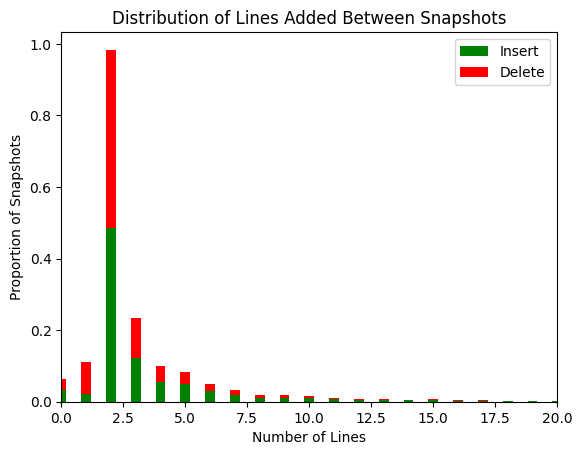

In [27]:
inserted = fail_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_fail
deleted = fail_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_fail

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 20)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

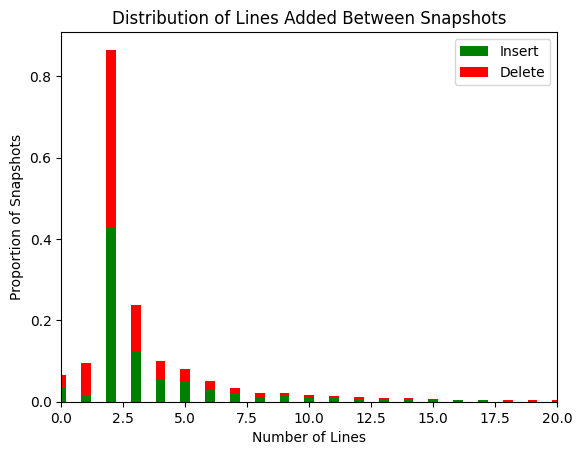

In [28]:
inserted = success_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_success
deleted = success_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_success

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 20)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

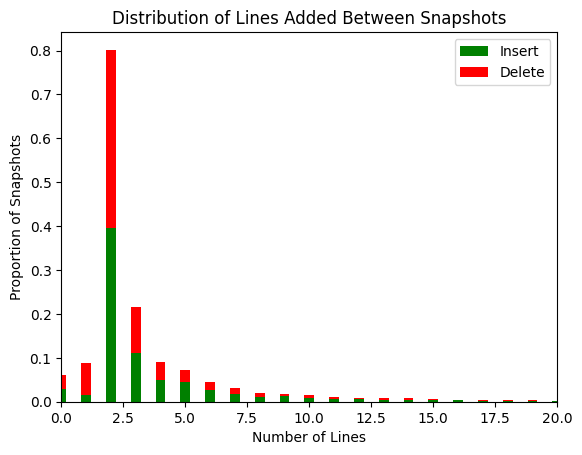

In [29]:
inserted = df_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots
deleted = df_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 20)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

I decided to define the number of changed lines as the maximum between the inserted lines and the deleted lines.

In [30]:
# Look on specific quetions
question = '487.0 102'
specific_quetion_success = df_with_snapshots[(df_with_snapshots['AssignmentID+ProblemID'] == question) & (df_with_snapshots['num_snapshots'] >= 8) & (df_with_snapshots['num_snapshots'] <= 10) & (df_with_snapshots['success'] == 1)]
specific_quetion_success = specific_quetion_success.head(8)

specific_quetion_fail = df_with_snapshots[(df_with_snapshots['AssignmentID+ProblemID'] == question) & (df_with_snapshots['num_snapshots'] >= 8) & (df_with_snapshots['num_snapshots'] <= 10) & (df_with_snapshots['success'] == 0)]
specific_quetion_fail = specific_quetion_fail.head(8)

In [31]:
def plot_snapshot(specific_quetion):
    for index, row in specific_quetion.iterrows():
        snapshots = list(range(1, row['num_snapshots']))
        plt.plot(snapshots, max(row['deleted'], row['inserted']), marker='o', label=row['SubjectID'])

    plt.xlabel('Snapshots')
    plt.ylabel('Changed Lines')
    plt.title('Changed Lines over Snapshots')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


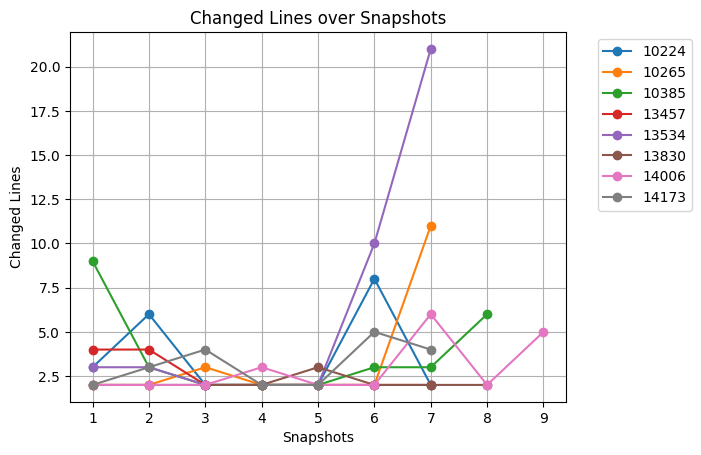

In [32]:
plot_snapshot(specific_quetion_success)

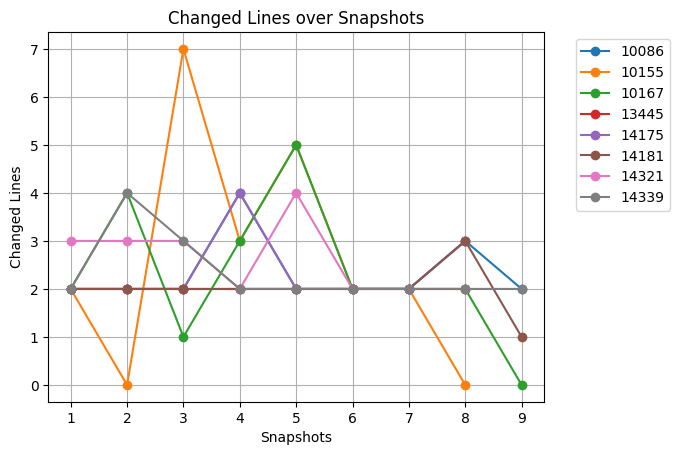

In [33]:
plot_snapshot(specific_quetion_fail)

#### Explore Students Who not Finish The Question

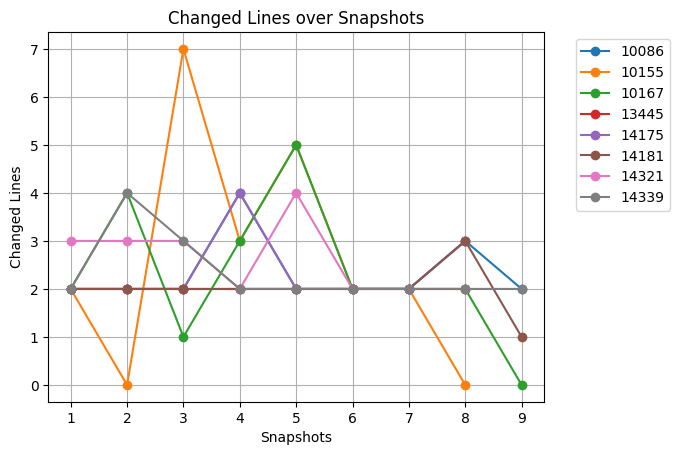

In [34]:
plot_snapshot(specific_quetion_fail)

In [35]:
a = df_with_snapshots[(df_with_snapshots['SubjectID'] == 13808) & (df_with_snapshots['AssignmentID+ProblemID'] == '487.0 102')]['Snapshots'].iloc[0]
for i in a:
    print(i)

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0, 2).equals(str.substring(string - 2 , string)) {
        return str.substring(2, string);
    }
    else {
        return string;
    }
}

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0, 2).equals(str.substring(string - 2 , string))) {
        return str.substring(2, string);
    }
    else {
        return string;
    }
}

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0, 2).equals(str.substring(string - 2 , string))) {
        return str.substring(2, string);
    }
    else {
        return str;
    }
}

public String without2(String str) 
{
    int string = str.length();
    if (string == 2) {
        return "";
    }
    else if (str.substring(0,

In [36]:
df_fail = df[df['success'] == 0]

snapshots_vs_score = {}
for index, row in df_fail.iterrows():
    if row['AssignmentID+ProblemID'] not in snapshots_vs_score:
        snapshots_vs_score[row['AssignmentID+ProblemID']] = {}
    for i in range (1, row['num_snapshots'] + 1):
        if i not in snapshots_vs_score[row['AssignmentID+ProblemID']]:
            snapshots_vs_score[row['AssignmentID+ProblemID']][i] = []
        snapshots_vs_score[row['AssignmentID+ProblemID']][i].append(row['Score'][i - 1])

avg_snapshots_vs_score = {}
len_snapshots_vs_score = {}
for key, value in snapshots_vs_score.items():
    avg_snapshots_vs_score[key] = {}
    len_snapshots_vs_score[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_score[key][k] = sum(v) / len(v)
        len_snapshots_vs_score[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_score.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'AssignmentID+ProblemID': key, 'Snapshot': k, 'Average Score': v, 'Number of Students': len_snapshots_vs_score[key][k]})

df_snapshots_vs_score = pd.DataFrame(data)
df_snapshots_vs_score

,AssignmentID+ProblemID,Snapshot,Average Score,Number of Students
0,487.0 25,1,0.234014,35
1,487.0 25,2,0.248848,31
2,487.0 25,3,0.374384,29
3,487.0 25,4,0.277778,24
4,487.0 25,5,0.482402,23
...,...,...,...,...
1329,487.0 17,8,0.000000,1
1330,487.0 17,9,0.346154,1
1331,487.0 17,10,0.000000,1
1332,487.0 17,11,0.615385,1


In [37]:
# arrange by limit to 10 snapshots and at least 5 students
df_snapshots_vs_score_10 = df_snapshots_vs_score[(df_snapshots_vs_score['Snapshot'] <= 10) & (df_snapshots_vs_score['Number of Students'] >= 5)]

In [38]:
df_all = df_snapshots_vs_score.groupby('Snapshot').apply(lambda x: pd.Series({
    'mean_score': x['Average Score'].mean(),
    'number_of_students': x['Number of Students'].sum(),
})).reset_index()

/tmp/ipykernel_429735/2873527491.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_snapshots_vs_score.groupby('Snapshot').apply(lambda x: pd.Series({


The mean score is problemtic (The number of student is decrease)

<Axes: title={'center': 'Score of Student not Finish the Question by Snapshots'}, xlabel='Snapshots', ylabel='Mean Score'>

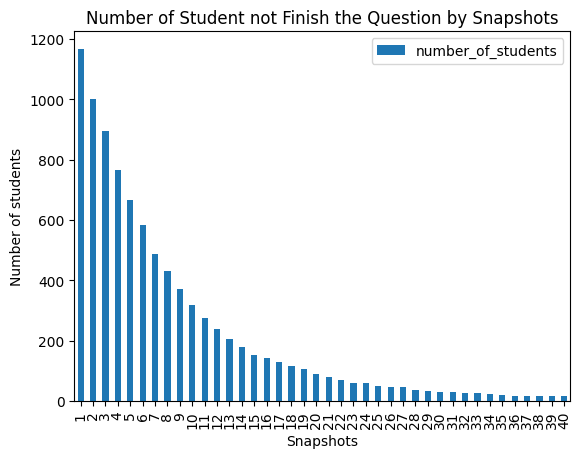

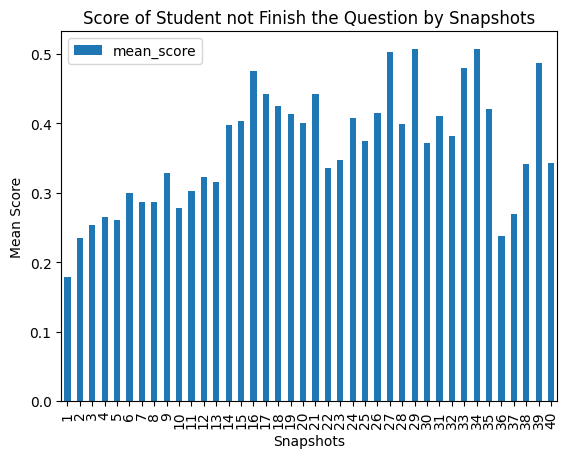

In [39]:
df_snapshots_vs_score_40 = df_all.head(40)
df_snapshots_vs_score_40.plot(x='Snapshot', y='number_of_students', kind='bar', xlabel='Snapshots', ylabel='Number of students', title='Number of Student not Finish the Question by Snapshots')
df_snapshots_vs_score_40.plot(x='Snapshot', y='mean_score', kind='bar', xlabel='Snapshots', ylabel='Mean Score', title='Score of Student not Finish the Question by Snapshots')


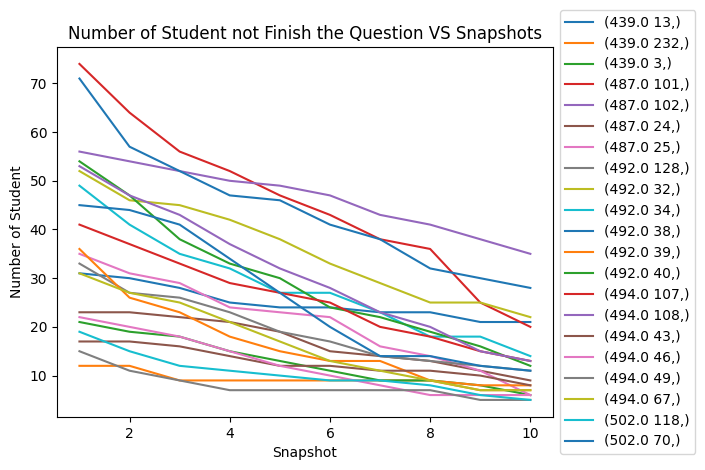

In [40]:
df_filter_snapshots_vs_score_10 = df_snapshots_vs_score_10.groupby('AssignmentID+ProblemID').filter(lambda x: len(x) == 10)
fig, ax = plt.subplots()
for key, grp in df_filter_snapshots_vs_score_10.groupby(['AssignmentID+ProblemID']):
    ax = grp.plot(ax=ax, kind='line', x='Snapshot', y='Number of Students', ylabel='Number of Student', title='Number of Student not Finish the Question VS Snapshots',  label=key)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

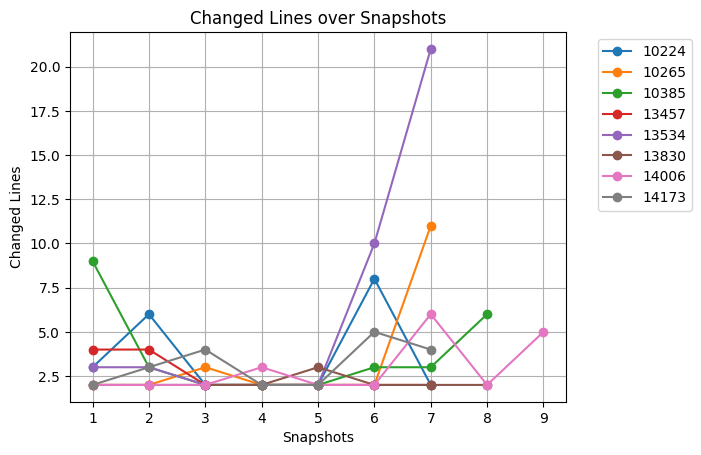

In [41]:
plot_snapshot(specific_quetion_success)

# Define Struggling Student

In [42]:
# measure avg without student who take a break (more than 10 minutes between snapshots)
df_without_break = df_with_snapshots[df_with_snapshots['time_between_snapshots'].apply(lambda x: max(x) < 900)]
df_without_break_grouped = df_without_break.groupby(['AssignmentID+ProblemID'])
top_20 = int(time_stat['number_of_students'].mean() // 5)

# Calculate average time to solve for each group
avg_time_to_solve = df_without_break_grouped['time_to_solve'].mean()

# Calculate the top 20 time to solve for each group
top_20_time = df_without_break_grouped['time_to_solve'].apply(lambda x: pd.Series(sorted(x)[:top_20]).mean())

# Calculate average attempts for each group
avg_attempts = df_without_break_grouped['num_snapshots'].mean()

# Calculate the top 20 attempts for each group
top_20_attempts = df_without_break_grouped['num_snapshots'].apply(lambda x: pd.Series(sorted(x)[:top_20]).mean())

variance_time_to_solve = df_without_break_grouped['time_to_solve'].var()

std_dev_time_to_solve = df_without_break_grouped['time_to_solve'].std()

variance_num_snapshots = df_without_break_grouped['num_snapshots'].var()

std_dev_num_snapshots = df_without_break_grouped['num_snapshots'].std()


# Combine the results into a DataFrame
result_df = pd.DataFrame({
    'avg_time_to_solve': avg_time_to_solve,
    'top_20_time': top_20_time,
    'avg_attempts': avg_attempts,
    'top_20_attempts': top_20_attempts,
    'variance_time_to_solve': variance_time_to_solve,
    'std_dev_time_to_solve': std_dev_time_to_solve,
    'variance_num_snapshots': variance_num_snapshots,
    'std_dev_num_snapshots': std_dev_num_snapshots
}).reset_index()

result_df


,AssignmentID+ProblemID,avg_time_to_solve,top_20_time,avg_attempts,top_20_attempts,variance_time_to_solve,std_dev_time_to_solve,variance_num_snapshots,std_dev_num_snapshots
0,439.0 1,101.274854,8.641026,3.280702,2.000000,81098.165187,284.777396,16.226625,4.028229
1,439.0 12,113.626866,10.846154,3.552239,2.000000,85973.844686,293.212968,42.549882,6.523027
2,439.0 13,509.898230,47.897436,7.619469,2.051282,297163.656264,545.127193,41.321219,6.428158
3,439.0 232,302.909091,14.230769,6.090909,2.000000,176775.236515,420.446473,42.688797,6.533666
4,439.0 233,185.266667,17.102564,4.487179,2.000000,70171.732646,264.899476,13.993391,3.740774
5,439.0 234,178.525822,12.307692,4.253521,2.000000,70148.127868,264.854919,11.397688,3.376046
6,439.0 235,230.854369,26.641026,4.184466,2.000000,99695.432347,315.745835,9.107270,3.017825
7,439.0 236,187.528571,18.666667,4.300000,2.000000,67403.733630,259.622290,12.957416,3.599641
8,439.0 3,236.333333,20.025641,4.848039,2.000000,88117.247947,296.845495,18.434922,4.293591
9,439.0 5,238.675258,19.666667,5.010309,2.000000,109088.210058,330.285044,19.730463,4.441899


Time - 2 std

In [43]:
print("avg time to solve: ", result_df['avg_time_to_solve'].mean())
print("std dev time to solve:",result_df['std_dev_time_to_solve'].mean())

avg time to solve:  264.6894094512125
std dev time to solve: 340.5461581691673


In [44]:
columns = ['SubjectID', 'AssignmentID+ProblemID', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'Snapshots']

data = [['SubjectID', 'AssignmentID+ProblemID', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'Snapshots']]

for index, row in df_without_break.iterrows():
    problem = row['AssignmentID+ProblemID']
    avg = result_df[result_df['AssignmentID+ProblemID'] == problem]['avg_time_to_solve'].values[0]
    std = result_df[result_df['AssignmentID+ProblemID'] == problem]['std_dev_time_to_solve'].values[0]
    if row['time_to_solve'] > avg + 2 * std:
        data.append([row['SubjectID'], row['AssignmentID+ProblemID'], row['num_snapshots'], row['time_to_solve'], row['time_between_snapshots'], row['Max.Score'], row['Snapshots']])

time_2_std = pd.DataFrame(data[1:], columns=columns)

In [45]:
time_2_std = time_2_std.sort_values(by=['SubjectID'])
time_2_std

,SubjectID,AssignmentID+ProblemID,num_snapshots,time_to_solve,time_between_snapshots,Max.Score,Snapshots
0,263,502.0 57,8,836,"[23, 16, 84, 14, 406, 32, 261]",1.000000,[public class FizzArray {\r\n\r\n\r\npublic st...
1,2411,487.0 22,8,1992,"[170, 401, 50, 117, 483, 653, 118]",1.000000,"[public int noTeenSum(int a, int b, int c)\r\n..."
2,4419,439.0 5,18,2010,"[25, 45, 16, 88, 48, 9, 89, 214, 117, 47, 6, 6...",1.000000,"[public boolean answerCell(boolean isMorning, ..."
3,6048,487.0 22,3,1000,"[118, 882]",1.000000,"[public int noTeenSum(int a, int b, int c)\r\n..."
4,7081,494.0 104,11,936,"[12, 18, 315, 20, 502, 1, 1, 9, 24, 34]",0.333333,[public int[] zeroMax(int[] nums)\r\n{\r\n ...
...,...,...,...,...,...,...,...
402,14504,487.0 100,11,771,"[21, 105, 48, 41, 16, 418, 29, 28, 43, 22]",0.000000,"[public int roundSum(int a, int b, int c)\r\n{..."
403,14505,492.0 31,12,1234,"[710, 25, 113, 6, 135, 60, 23, 63, 56, 34, 9]",1.000000,"[public String repeatEnd(String str, int n)\r\..."
405,14508,494.0 41,13,765,"[31, 5, 23, 41, 72, 351, 17, 33, 29, 91, 12, 60]",1.000000,[public int sum3(int[] nums)\r\n{\r\n for (...
404,14508,439.0 235,17,1065,"[61, 99, 27, 122, 58, 236, 18, 67, 7, 50, 124,...",1.000000,"[public int dateFashion(int you, int date)\r\n..."


1 Score

In [46]:
df_1_score = df_with_snapshots_include_1_attampt[df_with_snapshots_include_1_attampt['Max.Score'] != 1]

In [47]:
print("number of student with only 1 attampt:", len(df_1_score[df_1_score['num_snapshots'] == 1]))

number of student with only 1 attampt: 165


In [48]:
df_1_score

,SubjectID,CourseSectionID,AssignmentID+ProblemID,CodeStateID,Score,ServerTimestamp,num_snapshots,time_to_solve,time_between_snapshots,success,Max.Score,Snapshots
18,106,410.0,487.0 25,"[1788943, 1788946, 1788955]","[0.0, 0.761905, 0.809524]","[2019-03-09T00:55:05, 2019-03-09T00:55:18, 201...",3,91,"[13, 78]",0,0.809524,"[public boolean evenlySpaced(int a, int b, int..."
60,714,410.0,439.0 1,"[1751531, 1751542]","[0.0, 0.333333]","[2019-02-25T04:53:57, 2019-02-25T04:54:20]",2,23,[23],0,0.333333,"[public int sortaSum(int a, int b)\r\n{\r\n ..."
83,714,410.0,492.0 34,[1829241],[0.714286],[2019-03-25T03:58:57],1,0,[],0,0.714286,[public String zipZap(String str)\r\n{\r\n ...
85,714,410.0,492.0 37,"[1829090, 1829115]","[0.0, 0.933333]","[2019-03-25T03:53:25, 2019-03-25T03:54:00]",2,35,[35],0,0.933333,"[public boolean endOther(String a, String b)\r..."
89,1805,407.0,492.0 40,[1815501],[0.0769231],[2019-03-23T23:32:28],1,0,[],0,0.076923,[public String getSandwich(String str)\r\n{\r\...
...,...,...,...,...,...,...,...,...,...,...,...,...
16068,14506,410.0,492.0 40,"[1825412, 1825419, 1825456, 1825471, 1825489, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.769231]","[2019-03-25T01:44:16, 2019-03-25T01:44:27, 201...",6,189,"[11, 66, 44, 45, 23]",0,0.769231,[public String getSandwich(String str)\r\n{\r\...
16078,14506,410.0,494.0 67,"[1844866, 1844867, 1869366, 1869387]","[0.0, 0.35, 0.9, 0.9]","[2019-04-08T23:28:17, 2019-04-08T23:28:31, 201...",4,15365,"[14, 15137, 214]",0,0.900000,[public boolean has77(int[] nums)\r\n{\r\n ...
16151,14508,410.0,494.0 107,"[1860311, 1860312, 1860317, 1860319, 1860323, ...","[0.0, 0.0, 0.0909091, 0.181818, 0.181818, 0.18...","[2019-04-10T21:00:13, 2019-04-10T21:00:40, 201...",33,3332,"[27, 63, 22, 126, 20, 18, 19, 13, 176, 46, 40,...",0,0.909091,[public int countClumps(int[] nums)\r\n{\r\n ...
16152,14508,410.0,494.0 108,"[1860527, 1860536, 1860537, 1860538, 1860544, ...","[0.0, 0.0, 0.0, 0.0, 0.263158, 0.0, 0.0, 0.0, ...","[2019-04-10T22:05:11, 2019-04-10T22:08:45, 201...",17,4680,"[214, 13, 19, 161, 44, 26, 28, 10, 3848, 18, 1...",0,0.263158,[public int[] fix45(int[] nums)\r\n{\r\n fo...


All

In [49]:
df_1_score['time_between_snapshots'] = df_1_score['time_between_snapshots'].apply(tuple)
time_2_std['time_between_snapshots'] = time_2_std['time_between_snapshots'].apply(tuple)

time_2_std['Snapshots'] = time_2_std['Snapshots'].apply(tuple)
df_1_score['Snapshots'] = df_1_score['Snapshots'].apply(tuple)


df_all = pd.merge(df_1_score, time_2_std, how='outer', indicator=True)
df_all

/tmp/ipykernel_429735/3708573676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_score['time_between_snapshots'] = df_1_score['time_between_snapshots'].apply(tuple)
/tmp/ipykernel_429735/3708573676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_score['Snapshots'] = df_1_score['Snapshots'].apply(tuple)


,SubjectID,CourseSectionID,AssignmentID+ProblemID,CodeStateID,Score,ServerTimestamp,num_snapshots,time_to_solve,time_between_snapshots,success,Max.Score,Snapshots,_merge
0,106,410.0,487.0 25,"[1788943, 1788946, 1788955]","[0.0, 0.761905, 0.809524]","[2019-03-09T00:55:05, 2019-03-09T00:55:18, 201...",3,91,"(13, 78)",0.0,0.809524,"(public boolean evenlySpaced(int a, int b, int...",left_only
1,263,NaN,502.0 57,NaN,NaN,NaN,8,836,"(23, 16, 84, 14, 406, 32, 261)",NaN,1.000000,(public class FizzArray {\r\n\r\n\r\npublic st...,right_only
2,714,410.0,439.0 1,"[1751531, 1751542]","[0.0, 0.333333]","[2019-02-25T04:53:57, 2019-02-25T04:54:20]",2,23,"(23,)",0.0,0.333333,"(public int sortaSum(int a, int b)\r\n{\r\n ...",left_only
3,714,410.0,492.0 34,[1829241],[0.714286],[2019-03-25T03:58:57],1,0,(),0.0,0.714286,(public String zipZap(String str)\r\n{\r\n ...,left_only
4,714,410.0,492.0 37,"[1829090, 1829115]","[0.0, 0.933333]","[2019-03-25T03:53:25, 2019-03-25T03:54:00]",2,35,"(35,)",0.0,0.933333,"(public boolean endOther(String a, String b)\r...",left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,14508,NaN,439.0 235,NaN,NaN,NaN,17,1065,"(61, 99, 27, 122, 58, 236, 18, 67, 7, 50, 124,...",NaN,1.000000,"(public int dateFashion(int you, int date)\r\n...",right_only
1506,14508,410.0,494.0 107,"[1860311, 1860312, 1860317, 1860319, 1860323, ...","[0.0, 0.0, 0.0909091, 0.181818, 0.181818, 0.18...","[2019-04-10T21:00:13, 2019-04-10T21:00:40, 201...",33,3332,"(27, 63, 22, 126, 20, 18, 19, 13, 176, 46, 40,...",0.0,0.909091,(public int countClumps(int[] nums)\r\n{\r\n ...,left_only
1507,14508,410.0,494.0 108,"[1860527, 1860536, 1860537, 1860538, 1860544, ...","[0.0, 0.0, 0.0, 0.0, 0.263158, 0.0, 0.0, 0.0, ...","[2019-04-10T22:05:11, 2019-04-10T22:08:45, 201...",17,4680,"(214, 13, 19, 161, 44, 26, 28, 10, 3848, 18, 1...",0.0,0.263158,(public int[] fix45(int[] nums)\r\n{\r\n fo...,left_only
1508,14508,NaN,494.0 41,NaN,NaN,NaN,13,765,"(31, 5, 23, 41, 72, 351, 17, 33, 29, 91, 12, 60)",NaN,1.000000,(public int sum3(int[] nums)\r\n{\r\n for (...,right_only


### Not in use definitions

Struggling student = ((time > 5 min.) AND (time > 2 * Baseline time) AND (# attempts > 3) AND (# attempts > 2 * Baseline attempts)) OR (time > 15 min.) 

In [50]:
columns = ['SubjectID', 'AssignmentID+ProblemID', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'Snapshots']

data = [['SubjectID', 'AssignmentID+ProblemID', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'Snapshots']]

for index, row in df_without_break.iterrows():
    problem = row['AssignmentID+ProblemID']
    if row['time_to_solve'] > 15 * 60 or (row['time_to_solve'] > 5 * 60 and row['time_to_solve'] > 2 * result_df[result_df['AssignmentID+ProblemID'] == problem]['top_20_time'].values[0] and \
        row['num_snapshots'] > 3 and row['num_snapshots'] > 2 * result_df[result_df['AssignmentID+ProblemID'] == problem]['top_20_attempts'].values[0]):
        data.append([row['SubjectID'], row['AssignmentID+ProblemID'], row['num_snapshots'], row['time_to_solve'], row['time_between_snapshots'], row['Max.Score'], row['Snapshots']])

df_definition = pd.DataFrame(data[1:], columns=columns)

In [51]:
df_definition = df_definition.sort_values(by=['SubjectID'])
df_definition

,SubjectID,AssignmentID+ProblemID,num_snapshots,time_to_solve,time_between_snapshots,Max.Score,Snapshots
0,106,487.0 102,11,551,"[16, 17, 161, 24, 10, 179, 11, 30, 43, 60]",1.0,[public String without2(String str) \r\n{\r\n ...
1,263,439.0 5,8,336,"[34, 20, 24, 13, 22, 30, 193]",1.0,"[public boolean answerCell(boolean isMorning, ..."
2,263,502.0 57,8,836,"[23, 16, 84, 14, 406, 32, 261]",1.0,[public class FizzArray {\r\n\r\n\r\npublic st...
3,2411,439.0 5,5,495,"[23, 63, 317, 92]",1.0,"[public boolean answerCell(boolean isMorning, ..."
4,2411,487.0 22,8,1992,"[170, 401, 50, 117, 483, 653, 118]",1.0,"[public int noTeenSum(int a, int b, int c)\r\n..."
...,...,...,...,...,...,...,...
1870,14508,494.0 41,13,765,"[31, 5, 23, 41, 72, 351, 17, 33, 29, 91, 12, 60]",1.0,[public int sum3(int[] nums)\r\n{\r\n for (...
1867,14508,439.0 235,17,1065,"[61, 99, 27, 122, 58, 236, 18, 67, 7, 50, 124,...",1.0,"[public int dateFashion(int you, int date)\r\n..."
1868,14508,439.0 5,7,330,"[27, 13, 156, 71, 43, 20]",1.0,"[public boolean answerCell(boolean isMorning, ..."
1869,14508,494.0 106,8,901,"[15, 34, 26, 23, 756, 33, 14]",1.0,"[public boolean sameEnds(int[] nums, int n)\r\..."


Submission Number 

In [52]:
columns = ['SubjectID', 'AssignmentID+ProblemID', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'Snapshots']

data = [['SubjectID', 'AssignmentID+ProblemID', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'Snapshots']]

for index, row in df_without_break.iterrows():
    problem = row['AssignmentID+ProblemID']
    avg = result_df[result_df['AssignmentID+ProblemID'] == problem]['variance_num_snapshots'].values[0]
    std = result_df[result_df['AssignmentID+ProblemID'] == problem]['std_dev_num_snapshots'].values[0]
    if row['num_snapshots'] > avg + 2 * std:
        data.append([row['SubjectID'], row['AssignmentID+ProblemID'], row['num_snapshots'], row['time_to_solve'], row['time_between_snapshots'], row['Max.Score'], row['Snapshots']])

num_attampts_2_std = pd.DataFrame(data[1:], columns=columns)

In [53]:
num_attampts_2_std

,SubjectID,AssignmentID+ProblemID,num_snapshots,time_to_solve,time_between_snapshots,Max.Score,Snapshots
0,263,502.0 57,8,836,"[23, 16, 84, 14, 406, 32, 261]",1.0000,[public class FizzArray {\r\n\r\n\r\npublic st...
1,4840,502.0 57,8,32,"[3, 1, 0, 0, 1, 13, 14]",1.0000,[public int[] fizzArray(int n)\r\n{\r\n int...
2,9948,502.0 71,18,1295,"[72, 13, 230, 29, 2, 1, 23, 20, 295, 324, 26, ...",1.0000,[public boolean canBalance(int[] nums)\r\n{\r\...
3,10155,487.0 20,11,440,"[67, 96, 43, 27, 25, 45, 24, 14, 64, 35]",1.0000,"[public int loneSum(int a, int b, int c)\r\n{\..."
4,10159,494.0 44,6,207,"[17, 5, 155, 5, 25]",1.0000,[public int countEvens(int[] nums)\r\n{\r\n ...
...,...,...,...,...,...,...,...
79,14493,502.0 71,21,1013,"[11, 110, 46, 78, 9, 23, 12, 23, 73, 43, 16, 1...",0.5625,[public boolean canBalance(int[] nums)\r\n{\r\...
80,14499,494.0 46,36,3269,"[359, 303, 29, 10, 84, 11, 57, 48, 102, 69, 11...",1.0000,"[public boolean isEverywhere(int[] nums, int v..."
81,14503,494.0 41,13,635,"[10, 135, 17, 170, 16, 38, 24, 39, 13, 17, 24,...",1.0000,[public int sum3(int[] nums)\r\n{\r\n int x...
82,14508,439.0 235,17,1065,"[61, 99, 27, 122, 58, 236, 18, 67, 7, 50, 124,...",1.0000,"[public int dateFashion(int you, int date)\r\n..."


## Examples

In [54]:
time = df_all[(df_all['AssignmentID+ProblemID'] == '502.0 71') & (df_all['_merge'] == 'right_only')]
score = df_all[(df_all['AssignmentID+ProblemID'] == '502.0 71') & (df_all['_merge'] == 'left_only')]

### Score Examples

In [55]:
print("Max Score:", score['Max.Score'].iloc[1], "\nExplanition:", "The student is struggling because he tried only once. The main mistake was that he checked the balance only at the end of the code, and with more attempts, he would have caught it.\n")

for i in score['Snapshots'].iloc[3]:
    print(i)

Max Score: 0.5625 
Explanition: The student is struggling because he tried only once. The main mistake was that he checked the balance only at the end of the code, and with more attempts, he would have caught it.

public boolean canBalance(int[] nums)
{
    int left=0;
    int right=0;
    for(int i =0; i<nums.length;i+=1) {
        right += nums[i];
    }
    for(int i = 0; i <nums.length-2;i+=1) {
        left+=nums[i];
        right-=nums[i];
    }
    if(left==right) {
        return true;
    }
    return false;
        
}



In [56]:
print("Max Score:", score['Max.Score'].iloc[20], "\nExplanition: The student is struggling because he gave up after 2 attempts, even though his mistake was minor (he summed twice and did not remove in the 'right' part). He preferred to return 'true' instead of trying to fix the issue.", "\n")

for i in score['Snapshots'].iloc[20]:
    print(i)

Max Score: 0.9375 
Explanition: The student is struggling because he gave up after 2 attempts, even though his mistake was minor (he summed twice and did not remove in the 'right' part). He preferred to return 'true' instead of trying to fix the issue. 

public boolean canBalance(int[] nums)
{
    int l = 0;
    int r;
    for (int i = 0; i < nums.length - 1; i++)
    {
        l = l + nums[i];
        r = nums[nums.length - 1];
    }
    for (int i = nums.length - 2; i > 0; i--)
    {
        if (l == r)
        {
            return true;
            l = l - nums[i];
            r = r + nums[i];
        }
    }
    return (l == r);
}

public boolean canBalance(int[] nums)
{
    int l = 0;
    int r = 0;
    for (int i = 0; i < nums.length - 1; i++)
    {
        l = l + nums[i];
        r = nums[nums.length - 1];
    }
    for (int i = nums.length - 2; i > 0; i--)
    {
        if (l == r)
        {
            return true;
            l = l - nums[i];
            r = r + nums[i];
   

### Time

In [57]:
time

,SubjectID,CourseSectionID,AssignmentID+ProblemID,CodeStateID,Score,ServerTimestamp,num_snapshots,time_to_solve,time_between_snapshots,success,Max.Score,Snapshots,_merge
72,9948,NaN,502.0 71,NaN,NaN,NaN,18,1295,"(72, 13, 230, 29, 2, 1, 23, 20, 295, 324, 26, ...",NaN,1.0,(public boolean canBalance(int[] nums)\r\n{\r\...,right_only
428,14185,NaN,502.0 71,NaN,NaN,NaN,3,808,"(692, 116)",NaN,1.0,(public boolean canBalance(int[] nums)\r\n{\r\...,right_only
543,14205,NaN,502.0 71,NaN,NaN,NaN,10,942,"(102, 13, 15, 32, 31, 563, 103, 10, 73)",NaN,1.0,(public boolean canBalance(int[] nums)\r\n{\r\...,right_only
551,14207,NaN,502.0 71,NaN,NaN,NaN,10,1699,"(850, 29, 132, 239, 125, 236, 45, 28, 15)",NaN,1.0,(public boolean canBalance(int[] nums)\r\n{\r\...,right_only
1146,14415,NaN,502.0 71,NaN,NaN,NaN,10,908,"(145, 39, 33, 44, 382, 28, 107, 28, 102)",NaN,1.0,(public boolean canBalance(int[] nums)\r\n{\r\...,right_only


In [58]:
print("Time:", time['time_to_solve'].iloc[1], "\nExplanition: The student is struggling because it took him almost 10 minutes to understand the problem (he forgot the parentheses). He made a lot of changes in his code in order to find it, even though his initial code was fine.", "\n")

for i in time['Snapshots'].iloc[1]:
    print(i)

Time: 808 
Explanition: The student is struggling because it took him almost 10 minutes to understand the problem (he forgot the parentheses). He made a lot of changes in his code in order to find it, even though his initial code was fine. 

public boolean canBalance(int[] nums)
{
    int left = 0;
	int right;
	for(int i = 0; i < nums.length - 1; i++)
    {
		left += nums[i];
		right = nums[nums.length-1];
    }
	for(int i = nums.length - 2; i > 0; i--)
	{
		if(left == right)
			return true;
		left -= nums[i];
		right += nums[i];
	}
	return (left == right);
}

public boolean canBalance(int[] nums)
{
    int left = 0;
	int right=0;
	for(int i = 0; i < nums.length - 1; i++)
    {
		left += nums[i];
		right = nums[nums.length-1];
    }
	for(int i = nums.length - 2; i > 0; i--)
	{
		if(left == right)
        {
			return true;
        }
		left -= nums[i];
		right += nums[i];
	}
	return (left == right);
}

public boolean canBalance(int[] nums)
{
    int first = 0;
    int second = 0;
      


In [59]:
print("Time:", time['time_to_solve'].iloc[2], "\nExplanition: I didn't see anything special except for the time and the unorganized code.", "\n")

for i in time['Snapshots'].iloc[2]:
    print(i)

Time: 942 
Explanition: I didn't see anything special except for the time and the unorganized code. 

public boolean canBalance(int[] nums)
{
    int sum = 0;
    for (int num : nums)
        sum += num;
    int sumSoFar = 0;
    for (int num : nums)
        sumSoFar += num;
        if (sum == 2 * sumSoFar)
            return true;
    return false;
}

public boolean canBalance(int[] nums)
{
    int sum = 0;
    for (int i = 0; i < nums.length; i++)
        sum += nums[i];
    int sumSoFar = 0;
    for (int i = 0; i < nums.length; i++)
        sumSoFar += num;
        if (sum == 2 * sumSoFar)
            return true;
    return false;
}

public boolean canBalance(int[] nums)
{
    int sum = 0;
    for (int i = 0; i < nums.length; i++)
        sum += nums[i];
    int sumSoFar = 0;
    for (int i = 0; i < nums.length; i++)
        sumSoFar += num[i];
        if (sum == 2 * sumSoFar)
            return true;
    return false;
}

public boolean canBalance(int[] nums)
{
    int sum = 0;
   

# Taxonomy

### Basic Tests

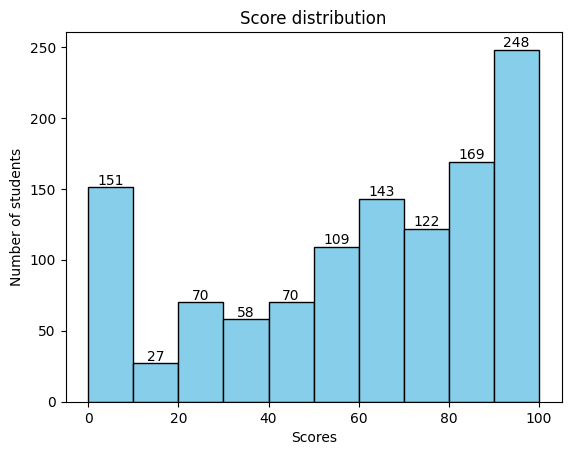

In [60]:
x = df[df['success'] == 0]['Max.Score'].apply(lambda x: 100 * x)
plt.title('Score distribution')
plt.xlabel('Scores')
plt.ylabel('Number of students')
n, bins, patches = plt.hist(x, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), int(patches[i].get_height()), ha='center', va='bottom')

plt.show()

### Computational constructs ​

In [61]:
questions = pd.read_excel(os.path.join(cwd, '../LinkTables/questions.xlsx'))

In [62]:
not_success_with_snapshots = df[df['success'] == 0]
len(not_success_with_snapshots)

1167

#### Help Functions

In [63]:
def analyze_java_code(code, elements):
    found_elements = []
    for element, pattern in elements.items():
        if re.search(pattern, code, re.IGNORECASE | re.DOTALL):
            found_elements.append(element)
    
    return found_elements

def create_df_computional_constract(elements):
    my_df = []
    for inx,row in df.iterrows():
        found_elements = analyze_java_code(row['Snapshots'][-1], elements)
        ass_id, prob_id = row["AssignmentID+ProblemID"].split()
        miss_element = []
        for element in questions.columns[3:-3]: # relavant columns
            if questions[(questions['AssignmentID'] == float(ass_id)) & (questions['ProblemID'] == float(prob_id))][element].values[0] == 1:
                if not element in found_elements:
                    miss_element.append(element)
        if len(miss_element):
            my_df.append([row['SubjectID'], ass_id, prob_id, row['Snapshots'][-1], row['success'], miss_element])
    df_computional_constract = pd.DataFrame(my_df, columns=['student_id', 'ass_id', 'prob_id', 'snapshots', 'success', 'missing elements'])
    print(df_computional_constract['success'].value_counts())
    return df_computional_constract

def create_con_dict(df):
    count_dict = {}
    for inx, row in df.iterrows():
        for e in row['missing elements']:
            if not e in count_dict.keys():
                count_dict[e] = 0
            count_dict[e] += 1
    return dict(sorted(count_dict.items(), key=lambda item: item[1]))

def create_graph(students_dict):
    categories = students_dict.keys()
    values = [i / sum(students_dict.values()) for i in students_dict.values()]

    # Create the bar graph
    plt.figure(figsize=(6, 4))
    plt.barh(categories, values, color='skyblue')
    plt.xlabel('Percents')
    plt.ylabel('Category')
    plt.title('Category Counts')
    plt.gca().invert_yaxis()  # Invert y-axis to have the largest values at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

#### Elements according to metaData of question

In [64]:
elements = {
    'If/Else': r'\bif\b|\belse\b',
    'NestedIf': r'if\s*\(.*?\)\s*(?:\{(?:[^{}]*?\{[^{}]*?\}|[^{}]*?)\s*if\s*\(.*?\)|\s*if\s*\()',
    'While': r'\bwhile\b|\bfor\b', # loop is loop
    'For': r'\bfor\b|\bwhile\b', # loop is loop 
    'NestedFor': r'for.*\{.*for',
    'Math+-*/': r'[+\-*/]',
    'Math%': r'%',
    'LogicAndNotOr': r'&&|\|\||!',
    'LogicCompareNum': r'[<>]=?|==|!=',
    'LogicBoolean': r'\btrue\b|\bfalse\b|if\s*\(\s*\w+\s*\)',
    'StringFormat': r'\bString\b',
    'StringConcat': r'\+(?=.*")|\.concat',
    'StringIndex': r'\.charAt|\.startsWith|\.lastIndexOf|\.endsWith|\.substring\s*\(.*\)|".*"',
    'StringLen': r'\.length\(\)',
    'StringEqual': r'\.equals|==(?=.*")',
    'CharEqual': r"==(?=.*')",
    'ArrayIndex': r'\[\s*[\w\d\s\+\-\*/]+\s*\]',
    'DefFunction': r'\b(public|private|protected)?\s+\w+\s+\w+\s*\('
}

In [65]:
df_computional_constract = create_df_computional_constract(elements)
struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 0])
not_struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 1])

success
1    6302
0     748
Name: count, dtype: int64


In [66]:
(6301/15012).__round__(2), (748/1167).__round__(2)

(0.42, 0.64)

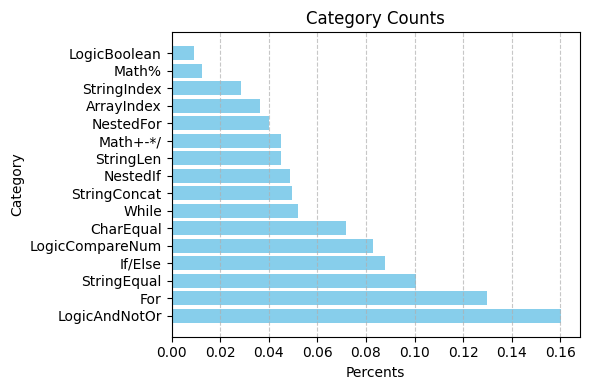

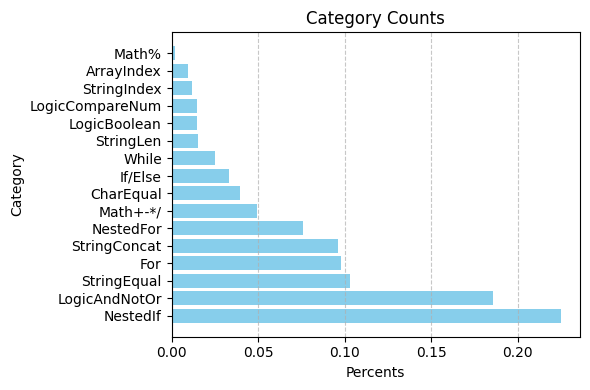

(None, None)

In [67]:
create_graph(struggle_dict), create_graph(not_struggle_dict)

#### Change The Question MetaData

In [68]:
elements = {
    'IfKnowledge': r'\bif\b|\belse\b|if\s*\(.*?\)\s*(?:\{[^{}]*\}|\{[^{}]*\{[^{}]*\}[^{}]*\})',
    'LoopsKnowledge': r'\bwhile\b|\bfor\b|\bdo\b|\bforeach\b',
    'Math+-*/%': r'[+\-*/%]',
    'LogicOperators': r'&&|\|\||!|[<>]=?|==|!=',
    'LogicBoolean': r'\btrue\b|\bfalse\b|if\s*\(\s*\w+\s*\)',
    'StringKnowledge': r'\bString\b|\+(?=.*")|\.concat\b|\.charAt\b|\.startsWith\b|\.lastIndexOf\b|\.endsWith\b|\.substring\b|".*"',
    'StringLen': r'\.length\s*\(\)',
    'StringEqual': r'\.equals\b|==(?=.*")',
    'CharEqual': r"==(?=.*')",
    'ArrayIndex': r'\[\s*[\w\d\s\+\-\*/]+\s*\]',
    'DefFunction': r'\b(public|private|protected)?\s+\w+\s+\w+\s*\('
}


In [69]:
questions['IfKnowledge'] = questions[['If/Else', 'NestedIf']].max(axis=1)
questions['StringKnowledge'] = questions[['StringConcat', 'StringIndex', 'StringFormat']].max(axis=1)
questions['LoopsKnowledge'] = questions[['While', 'For', 'NestedFor']].max(axis=1)
questions['Math+-*/%'] = questions[['Math+-*/', 'Math%']].max(axis=1)
questions['LogicOperators'] = questions[['LogicAndNotOr', 'LogicCompareNum']].max(axis=1)
questions = questions.drop(columns=['If/Else', 'NestedIf', 'StringConcat', 'StringIndex', 'StringFormat',
                      'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr', 'LogicCompareNum'])

In [70]:
df_computional_constract = create_df_computional_constract(elements)
struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 0])
not_struggle_dict = create_con_dict(df_computional_constract[df_computional_constract['success'] == 1])

success
1    1409
0     381
Name: count, dtype: int64


In [71]:
(1409/15012).__round__(2), (381/1167).__round__(2)

(0.09, 0.33)

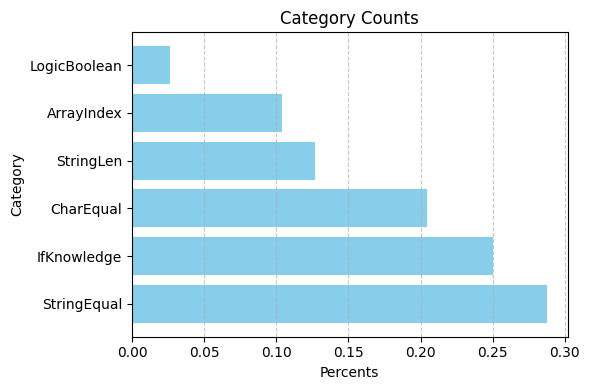

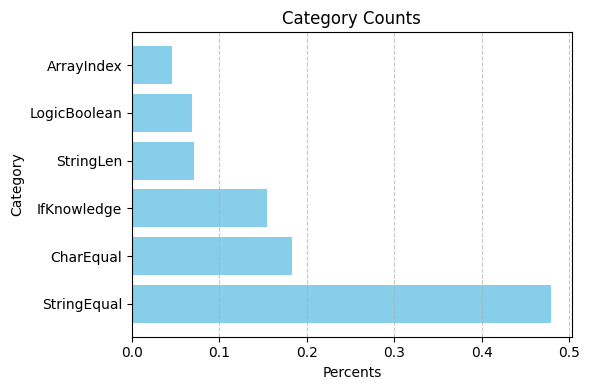

(None, None)

In [72]:
create_graph(struggle_dict), create_graph(not_struggle_dict)